In [1]:
import os, re
import pandas
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ConvertImageDtype, Normalize
import torchvision.transforms.functional as F

root_dir        = 'C:/Users/paula/Documents/Repositorio/' # directorio raíz
dataset_name     = 'MURA-v1.1' 
study_type       = 'XR_WRIST'
train = False
annotation_files   = {'train':'train_labeled.csv', 'test':'valid_labeled.csv'}
data_split_folders = {'train': 'train', 'test':'valid'}

In [2]:
# Defnición de clase MuraDataset para poner en un módulo que se importará
# El módulo es un fichero .py (por ejemplo muradataset.py) accesible (para simplificar, en misma carpeta)

import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class MuraDataset(Dataset):
    # La clase hereda de torch,utils.data.Dataset
    # Los datasets en pytorch deben tener Dataset como ancestro

    # Variables de clase, comunes para todos los objetos de la misma
    dataset_name       = 'MURA-v1.1' 
    annotation_files   = {'train':'train_labeled.csv', 'test':'valid_labeled.csv'}
    data_split_folders = {'train': 'train', 'test':'valid'}
    labels_map         = {0: 'negativo', 1:'positivo'}

    # Método de inicialización de los objetos de la clase. Sobreescribe al de Dataset
    def __init__(self, root_dir, study_type='XR_WRIST', train=True, rgb=True, transform=None, target_transform=None):

        self.root_dir = root_dir
        self.train = train
        self.rgb = rgb
        #self.img_dir = os.path.normpath(
        #    (os.path.join(root_dir, dataset_name, data_split_folders['train'], study_type) if train 
        #                else os.path.join(root_dir, dataset_name, data_split_folders['test'], study_type)))

        self.annotations_file =  os.path.normpath(
            (os.path.join(root_dir, dataset_name, annotation_files['train']) if train else 
                                  os.path.join(root_dir, dataset_name, annotation_files['test'])))
        all_img_labels  = pd.read_csv(self.annotations_file) # Se carga el fichero con todos los estudios
        # Se selecciona el tipo de estudio. EL data frame tiene la ruta a cada imagen y su etiqueta
        self.img_labels = all_img_labels.iloc[(all_img_labels['Path'].str.contains(study_type)).to_numpy()].copy()
        
        
        self.transform = transform
        self.target_transform = target_transform
    
    # Método de longitud del dataset. Sobreescribe al de Dataset
    def __len__(self):
        return len(self.img_labels)

    # Método para obtener una única imagen y su etiqueta correspondiente 
    def __getitem__(self, idx):
        # Ruta al fichero con la imagen
        img_path = os.path.join(self.root_dir, self.img_labels.iloc[idx, 0])
        
        im_mode= ImageReadMode.RGB if self.rgb else ImageReadMode.GRAY 
        image = read_image(img_path, mode=im_mode)
        
        # Se obtiene la etiqueta correspondiente
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
# Comprobamos que pueden leerse las imágenes en gris y en RGB
# en Pytorch las bandas son C (color),H (altura),W (anchura)
# Mientras que normalmente es H, W, C. Hay que tenerlo en cuenta para visualizar  
img_data = MuraDataset(root_dir, rgb=False)
sample_idx = torch.randint(len(img_data), size=(1,)).item()
img, label = img_data[sample_idx]

print(img.shape, '\t', img.dtype)
print('Pixel arbitrario:\t', img[:,10,150])

torch.Size([1, 512, 263]) 	 torch.uint8
Pixel arbitrario:	 tensor([60], dtype=torch.uint8)


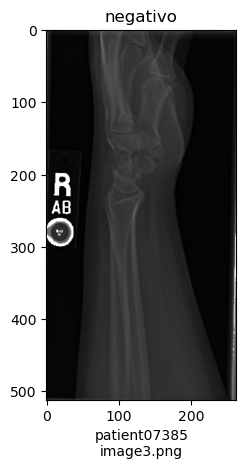

In [4]:
# Convertimos imagen de tensores a imagen PIL para representarla
plt.imshow(F.to_pil_image(img), cmap='gray')
patient = re.search(r'\bpatient\d+\b', img_data.img_labels.iloc[sample_idx,0]).group()

plt.xlabel(patient+'\n'+ os.path.basename(img_data.img_labels.iloc[sample_idx,0]))
plt.title(img_data.labels_map[label])
plt.show()

In [5]:
# Explícitamente pedimos que se lea como RGB, pues estaba puesto como gris
img_data.rgb=True
img, label = img_data[sample_idx]

print(img.shape, '\t', img.dtype)
print('Pixel arbitrario:\t', img[:,10,150])

torch.Size([3, 512, 263]) 	 torch.uint8
Pixel arbitrario:	 tensor([60, 60, 60], dtype=torch.uint8)


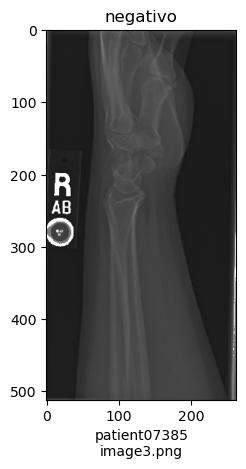

In [6]:
# Convertimos imagen de tensores a imagen PIL para representarla
plt.imshow(F.to_pil_image(img), cmap='gray')

patient = re.search(r'\bpatient\d+\b', img_data.img_labels.iloc[sample_idx,0]).group()
plt.xlabel(patient+'\n'+ os.path.basename(img_data.img_labels.iloc[sample_idx,0]))
plt.title(img_data.labels_map[label])
plt.show()

In [7]:
# La clase Dataset permite transformar las imágenes, para
# adecuarlas a la cadena posterior de procesado
# En el caso de DenseNet, podemos tomar de referencia
# https://pytorch.org/hub/pytorch_vision_densenet/
# La red espera imágenes RGB 

transform = Compose([
    # Se ajustan las dimensiones de la imagen al tamaño que espera la red neuronal
    Resize(size=(224,224)),
    # Las imágenes se convierten a punto flotante (eran enteras) 
     ConvertImageDtype(torch.float),
    # Se normalizan los valores. En el caso de imágenes grises con
    # tres canales, resultarán canales con valores diferentes
    # y se verán en color. Los píxeles pueden tener valores negativos
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ])

In [8]:
training_data = MuraDataset(
    root_dir=root_dir,
    study_type='XR_WRIST',
    train=True,
    rgb=True,
    transform=transform
    )

print('Tamaño del dataset de entrenamiento:\t', len(training_data))

test_data = MuraDataset(
    root_dir=root_dir,
    study_type='XR_WRIST',
    train=False,
    rgb=True,
    transform=transform
    )

print('Tamaño del dataset de test:\t', len(test_data))

Tamaño del dataset de entrenamiento:	 9752
Tamaño del dataset de test:	 659


torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-0.2684, -0.1450,  0.0779])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-2.0494, -1.9657, -1.7347])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-2.0665, -1.9832, -1.7522])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-2.0494, -1.9657, -1.7347])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.9295, -1.8431, -1.6127])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-2.1008, -2.0182, -1.7870])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.2788, -1.1779, -0.9504])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.3130, -1.2129, -0.9853])
torch.Size([3, 224, 224]) 	 torch.float32
Pixel arbitrario:	 tensor([-1.0904, -0.9853, -0.7587])


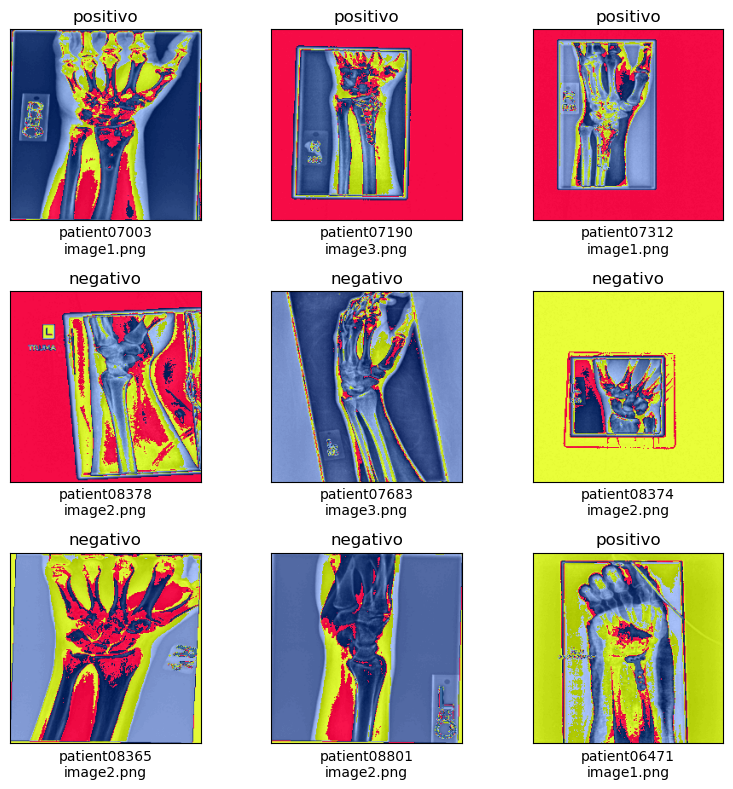

In [9]:
nrows, ncols = 3,3

fig, axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(8,8))
for r in range(nrows):
    for c in range(ncols):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()

        img, label = training_data[sample_idx]
        patient = re.search(r'\bpatient\d+\b', training_data.img_labels.iloc[sample_idx,0]).group()

        print(img.shape, '\t', img.dtype)
        print('Pixel arbitrario:\t', img[:,10,150])

        axs[r,c].set_title(training_data.labels_map[label])
        axs[r,c].set_xticks([])
        axs[r,c].set_yticks([])
        axs[r,c].set_xlabel(patient+'\n'+
                            os.path.basename(training_data.img_labels.iloc[sample_idx,0]))
        axs[r,c].imshow(F.to_pil_image(img), cmap='gray')

plt.tight_layout()

In [10]:
# Los dataloaders se hacen con la clase de Pytorch
# EL dataloader se encarga de ordenar aleatoriamiente las imágenes
# y de agruparlas en "batches" o grupos. La métrica de entrenamiento
# se calcula para las imágenes del batch (gradiente estocástico)
# En cada iteración el dataloader proporciona un "batch" completo
# El batch corresponde a la primera dimensión del tensor: B,C,H,W

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
print('Número de batches de entrenamiento:\t', len(train_dataloader))

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
print('Número de batches de test:\t', len(test_dataloader))

Número de batches de entrenamiento:	 153
Número de batches de test:	 11


Batch shape (images): torch.Size([64, 3, 224, 224])
Batch shape (labels): torch.Size([64])


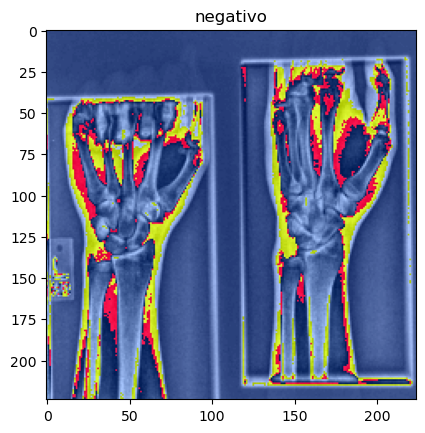

In [34]:
# Visualizamos la 0primera imagen del primer batch
# del conjunto de entrenamiento.
# Cada vez que se vuelva a ejecutar pasa al "batch" siguiente
train_imgs, train_labels = next(iter(train_dataloader))

print(f"Batch shape (images): {train_imgs.size()}")
print(f"Batch shape (labels): {train_labels.size()}")

img = train_imgs[0]
label = train_labels[0]

plt.imshow(F.to_pil_image(img), cmap="gray")
plt.title(training_data.labels_map[label.item()])
plt.show()

In [12]:
# Para continuar con el pipeline hay que recrear los dataloaders
# Pues se han consumido parcialmente al correr antes
# train_imgs, train_labels = next(iter(train_dataloader))

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
print('Número de batches de entrenamiento:\t', len(train_dataloader))

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
print('Número de batches de test:\t', len(test_dataloader))

Número de batches de entrenamiento:	 153
Número de batches de test:	 11


In [13]:
import torch

In [19]:
model = torch.hub.load('pytorch/vision:v0.17.1', 'densenet169', weights=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.17.1" to C:\Users\paula/.cache\torch\hub\v0.17.1.zip


In [20]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [22]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
next(iter(range(10)))

0

In [29]:
a=range(10)

In [33]:
print(next(iter(a)))
print(next(iter(a)))

0
0


In [31]:
next(iter(a))

0